<a href="https://colab.research.google.com/github/TANKIANAUN/AlgoDesign/blob/master/17096288_1_TanKianAun_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring Multi Layer Perceptron with EMNIST dataset

This individual assignment has four parts and is 15 marks in total. Submission deadline is 3rd June (Thursday), 12PM. Submission link (via Google Form) will be updated on Spectrum.

Again,there are no extra marks for early submission. If you are able to complete it rather quickly, consider how relatively easy you find the assignment to be and the fact that it is done and dusted as a reward itself.


#Background
In this assignment we will be creating a Multi Layer Perceptron to classify the EMNIST dataset. The link to the original paper is as below


https://arxiv.org/pdf/1702.05373v1.pdf

This dataset has more classes and relatively many more datapoints (about 800k) compared to the MNIST dataset. As in the paper, there are many data hierarchies 
but we will use '**By_merge**' in this assignment, and so you should have 47 classes. 

###**Notes**
* For each task and questions, there will be sample outputs. Sample outputs are often 'snippets' of the whole answer. Your answers do not have to match the sample outputs (most likely won't as your network is unique). But you are expected to produce outputs following the format shown by the sample outputs. 

* Training will take time. To enable GPU in colab, select Runtime-Change runtime type-GPU

* Once you've trained your model, you probably want to save it so that it can be reused later. To save the weights of the models

```
torch.save(model.state_dict(), "./model.weights")
from google.colab import files
files.download('model.weights')
```

* To load your downloaded weights to colab

```
from google.colab import files
uploaded = files.upload() #select the saved model.weights
```
 
* PyTorch doesn't save the model structure by default.So you need to copy paste your model class, build the model and load the weights



```
# build the model and load state
model = MLP()
model.load_state_dict(torch.load('model.weights'))
model = model.eval() 
```

If you are working locally, then https://pytorch.org/tutorials/beginner/saving_loading_models.html


##Updated 29th May 2PM
* Please use PyTorch and not Tensorflow or Keras. This is because one of the learning goal is to asses how well students can master PyTorch.


# Task 1. Create and implement MLP of your design to classify the EMNIST dataset


In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from google.colab import files

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [8]:
!pip install pytorch-model-summary
from pytorch_model_summary import summary

In [9]:
transformCustom = transforms.Compose([
                                transforms.ToTensor(), #this convert to tensor
                                transforms.Lambda(lambda x:x.view(-1))  #this flatten 28*28 into a 784 vector for each image
])


train = datasets.EMNIST(root='.',train=True, split='bymerge', transform=transformCustom, download=True)
test = datasets.EMNIST(root='.', train=False, split='bymerge', transform=transformCustom,download=True)


Extracting ./EMNIST/raw/emnist.zip to ./EMNIST/raw
Processing byclass


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [10]:
total_class = train.classes
print("total classes = ",len(total_class))
print(total_class)

total classes =  47
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [11]:
#Set DataLoader
batchSize = 128 

print("Length :")
print("train = {},  test= {}".format(len(train),len(test)))

print("batches : ")
train_loader = DataLoader(train, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test,batch_size=batchSize, shuffle=False) # no need to shuffle test data
print("train_loader = {},  test_loader = {}".format(len(train_loader),len(test_loader)))

Length :
train = 697932,  test= 116323
batches : 
train_loader = 5453,  test_loader = 909


In [ ]:
#Get some train info 
print(train)
print(train.data.shape)

print(train.targets.shape)
print("\n")

#Get some test info 
print(test)
print(test.data.shape)

print(test.targets.shape)

Dataset EMNIST
    Number of datapoints: 697932
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
torch.Size([697932, 28, 28])
torch.Size([697932])


Dataset EMNIST
    Number of datapoints: 116323
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
torch.Size([116323, 28, 28])
torch.Size([116323])


# Question 1

Q1: Is the dataset balanced? For both training and test dataset, print out the number of instances for each label (Sample output shown below. This is straightforward as we've done this before) and their percentage with meaningful labels. Which class/label is over/under represented?

## Q1 ANSWER
- As shown below code and output, the train and test dataset is not balanced as the percentage show should be around 2.12% for every class as there are in total of 47 classes. 
- Above show some results:

a) Assuming class that are over represented is class over or equal to 3%

b) Assuming class that are under represented is class under or equal to 1%

c) Other class is consider in the acceptable range

TRAIN DATASET

In [ ]:
# check instance and percentage of training dataset

#check class idx mapping
class_match = train.class_to_idx
inv_match = {v: k for k, v in class_match.items()}
print("class to idx \n",inv_match)

#create empty dict to store value
train_labels = train.targets
trainDict = { label:0 for label in range(len(train.classes))}  
print("\ncreate empty train dict\n",trainDict)

for label in train_labels:
  # getClass = inv_match[label.item()] 
  trainDict[label.item()]+=1  


print("--Number of instances for each classes--")
for key, n in trainDict.items():
  print("Label ",key,"(", inv_match[key],") :",n)

print("\nCheck total labels, should tally with number of samples")
totalLabel = sum(trainDict.values())
print(totalLabel)

over = []
under = []
inrange = []
print("\n--Imbalance data check: Percentage of instances for each classes--")
for key, n in trainDict.items():
  print(f'Label {key} ({inv_match[key]}) : {n/totalLabel*100:.2f}%')
  if n/totalLabel*100<=1:
    under.append(inv_match[key])
  elif n/totalLabel*100>=3:
    over.append(inv_match[key])
  else:
    inrange.append(inv_match[key])


class to idx 
 {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}

create empty train dict
 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0}
--Number of instances for each classes--
Label  0 ( 0 ) : 34618
Label  1 ( 1 ) : 38304
Label  2 ( 2 ) : 34307
Label  3 ( 3 ) : 35285
Label  4 ( 4 ) : 33656
Label  5 ( 5 ) : 31280
Label  6 ( 6 ) : 34150
Label  7 ( 7 ) : 36020


In [ ]:
#Train class
print("over represented class (>=3%) = ",over)
print("under represented class (<=1%) = ",under)
print("acceptable class= ",inrange)

over represented class (>=3%) =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O', 'S', 'e']
under represented class (<=1%) =  ['A', 'B', 'D', 'E', 'G', 'H', 'J', 'K', 'Q', 'R', 'X', 'Z', 'b', 'f', 'g', 'q']
acceptable class=  ['C', 'F', 'I', 'L', 'M', 'N', 'P', 'T', 'U', 'V', 'W', 'Y', 'a', 'd', 'h', 'n', 'r', 't']


TEST DATASET

In [ ]:
# check instance and percentage of testing dataset

#check class idx mapping
class_match = test.class_to_idx
inv_match = {v: k for k, v in class_match.items()}
print("class to idx \n",inv_match)

test_labels = test.targets
testDict = { label:0 for label in range(len(test.classes))}  
print("\ncreate empty test dict\n",testDict)

for label in test_labels:
  # getClass = inv_match[label.item()] 
  testDict[label.item()]+=1  


print("--Number of instances for each classes--")
for key, n in testDict.items():
  print("Label ",key,"(", inv_match[key],") :",n)

print("\nCheck total labels, should tally with number of samples")
totalLabel = sum(testDict.values())
print(totalLabel)

over = []
under = []
inrange = []
print("\n--Imbalance data check: Percentage of instances for each classes--")
for key, n in testDict.items():
  print(f'Label {key} ({inv_match[key]}) : {n/totalLabel*100:.2f}%')
  
  if n/totalLabel*100<=1:
    under.append(inv_match[key])
  elif n/totalLabel*100>=3:
    over.append(inv_match[key])
  else:
    inrange.append(inv_match[key])

class to idx 
 {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}

create empty test dict
 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0}
--Number of instances for each classes--
Label  0 ( 0 ) : 5745
Label  1 ( 1 ) : 6400
Label  2 ( 2 ) : 5765
Label  3 ( 3 ) : 5827
Label  4 ( 4 ) : 5498
Label  5 ( 5 ) : 5326
Label  6 ( 6 ) : 5787
Label  7 ( 7 ) : 5873
Label  8 

In [ ]:
# Test class
print("over represented class (>=3%) = ",over)
print("under represented class (<=1%) = ",under)
print("acceptable class= ",inrange)

over represented class (>=3%) =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O', 'S', 'e']
under represented class (<=1%) =  ['A', 'B', 'D', 'E', 'G', 'H', 'J', 'K', 'Q', 'R', 'X', 'Z', 'b', 'f', 'g', 'q']
acceptable class=  ['C', 'F', 'I', 'L', 'M', 'N', 'P', 'T', 'U', 'V', 'W', 'Y', 'a', 'd', 'h', 'n', 'r', 't']


# Question 2

Q2: How many learnable parameters does your model have?



In [ ]:
class MLP(nn.Module):
  def __init__(self,input_size, hidden_size,num_classes):
    super(MLP,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size) 
    self.layer2 = nn.Linear(hidden_size,num_classes)

  def forward(self,x): 

    out = self.layer1(x)
    #out = F.sigmoid(out) 
    out = torch.sigmoid(out)
    out = self.layer2(out)
 
    if not self.training:
      out = F.softmax(out,dim=1)
    return out

## Q2 ANSWER
- For MLP(784, 512, 47), i will have 426031 params shows as below

In [ ]:
pytorch_total_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The number of learnable parameters: {pytorch_total_learnable_params}')

print(summary(MLP(784, 512, 47), torch.zeros((1, 784)), show_input=False))

The number of learnable parameters: 426031
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 512]         401,920         401,920
          Linear-2             [1, 47]          24,111          24,111
Total params: 426,031
Trainable params: 426,031
Non-trainable params: 0
-----------------------------------------------------------------------


# Question 3

Q3: How does the training loss look like? Visualize both loss by epochs and minibatches. Sample output shown as below (training with 10 epochs, batch size 128)



## Q3-a ANSWER

In [7]:
#train
def train_model(model,train_loader):
  loss_fn = nn.CrossEntropyLoss() 
  opt = torch.optim.Adam(model.parameters()) #optimizer, optimization strategy-to escape the local minima and to converge quickly

  epochSize = 10 

  epochList = []
  lossList = []
  accuracyList = []
  total_train = len(train)
  trainCorrect = []

  batch = 0
  batchList = []
  batchLoss = []

  for epoch in range(epochSize):
    epochList.append(epoch)
    model.train() #training mode
    loss = 0
    correct = 0

    for input_batch, target_batch in train_loader:
      batchList.append(batch)

      opt.zero_grad() #zero the gradients
      predict_batch = model(input_batch) #fwd

      loss_batch = loss_fn(predict_batch,target_batch) #loss
      loss_batch.backward() #backward

      opt.step()#optimize i.e update weights
      
      batchLoss.append(loss_batch.item())

      loss += loss_batch.item()
      _, predicted = torch.max(predict_batch.data, 1)

      correct += ((predicted == target_batch).sum().item())
      batch += 1

    lossList.append(loss)
    trainCorrect.append(correct)

    accuracy = correct/total_train*100
    accuracyList.append(accuracy)

    print(f'Epoch: {epoch+1}  loss: {loss} accuracy: {accuracy}')
  return epochList, lossList, batchList, batchLoss,accuracyList 


In [ ]:

#initialize train model
model = MLP(784, 512, 47) #input_size,hidden_size,num_classes
#get results
epochList, lossList, batchList, batchLoss,accuracy_list = train_model(model,train_loader)

Epoch: 1  loss: 3656.216137290001 accuracy: 79.89417307130208
Epoch: 2  loss: 2163.275180503726 accuracy: 86.63594734157482
Epoch: 3  loss: 1908.0544761270285 accuracy: 87.86400394307755
Epoch: 4  loss: 1780.161602050066 accuracy: 88.45675509935064
Epoch: 5  loss: 1692.8039425984025 accuracy: 88.91854793876767
Epoch: 6  loss: 1630.1587817668915 accuracy: 89.18404658333476
Epoch: 7  loss: 1575.6555287018418 accuracy: 89.48006396038582
Epoch: 8  loss: 1534.9349963068962 accuracy: 89.67535519219638
Epoch: 9  loss: 1495.292030788958 accuracy: 89.87723732397998
Epoch: 10  loss: 1464.6712012141943 accuracy: 90.02381320816355


In [ ]:
#save and download model 
torch.save(model.state_dict(), "./model.weights")
files.download('model.weights')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

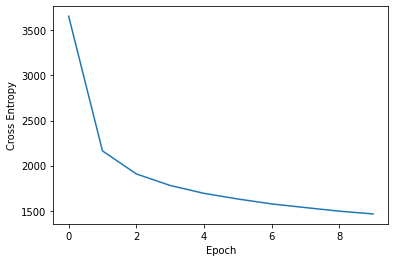

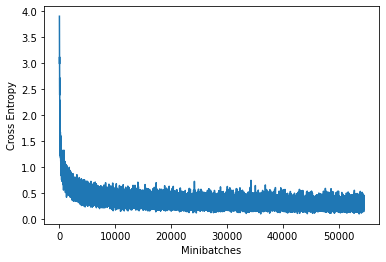

In [ ]:
# Plot figure 
# cross entropy vs epoch
plt.figure(0)
plt.plot(epochList, lossList)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")

plt.savefig("./epoch_cross_entropy.jpg")
files.download('epoch_cross_entropy.jpg')

# cross entropy vs minibatches
plt.figure(1)
plt.plot(batchList, batchLoss)
plt.xlabel("Minibatches")
plt.ylabel("Cross Entropy")


plt.savefig("./minibatches_cross_entropy.jpg")
files.download('minibatches_cross_entropy.jpg')

In [8]:
def test_model(model,test_loader):
  model.eval() # sets the model in evaluation mode 
  loss_fn = nn.CrossEntropyLoss() 
  total_test = len(test)
  testLoss = 0
  testCorrect = 0
  with torch.no_grad():
    for input_batch, target_batch in test_loader:
      output = model(input_batch)
      loss_batch = loss_fn(output,target_batch) #loss
      testLoss += loss_batch.item()
      _, predicted = torch.max(output.data, 1)
      testCorrect += ((predicted == target_batch).sum().item())

  testAccuracy = testCorrect/total_test*100
  return testAccuracy,testLoss


In [ ]:
testAccuracy,testError = test_model(model,test_loader)

Q3: What is the training and test accuracy? Sample output shown as below


## Q3-b ANSWER

In [ ]:
total_train = len(train)
total_test = len(test)
print("Training :")
print('number of train data = ',total_train)
print(f'number of wrongly predicted label = {int((100 - accuracy_list[-1])*total_train/100)}')
print(f'train accuracy = {round(accuracy_list[-1],2)} % ')

print("\nTesting :")
print('number of test data = ',total_test)
print(f'number of wrongly predicted label = {int((100 - testAccuracy)*total_test/100)} ')
print(f'test accuracy = {round(testAccuracy,2)} %')

Training :
number of train data =  697932
number of wrongly predicted label = 69627
train accuracy = 90.02 % 

Testing :
number of test data =  116323
number of wrongly predicted label = 13583 
test accuracy = 88.32 %


# Task 2. Unsure predictions


# Question 1
Q1: If we take our trained model and use the training data for prediction, for each label, how many times is the prediction unsure? Which label has the highest 'level of unsure'? Comment on your results

In [ ]:
uploaded = files.upload() #select the saved model.weights
# PyTorch doesn't save the model structure by default.So you need to copy paste your model class, build the model and load the weights
# build the model and load state
model = MLP(784, 512, 47)
model.load_state_dict(torch.load('model.weights'))
print(model)

Saving model.weights to model (1).weights
MLP(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=47, bias=True)
)


In [ ]:
import collections as collec

#reload the dataset to batch size 1 
train_loader = DataLoader(train)
test_loader = DataLoader(test)
print(len(train_loader),len(test_loader))

#get representative class and label
rep_class_idx = train.class_to_idx
rep_match = {v: k for k, v in rep_class_idx.items()}

697932 116323


In [ ]:

# create multidimensional dictionary to store value
trainDict_count = collec.defaultdict(lambda : collec.defaultdict(int))
trainDict_list = collec.defaultdict(lambda : collec.defaultdict(list))
#make sure is clear and empty at start
trainDict_count.clear()
trainDict_list.clear()

model.eval()

for data, labels in train_loader:
  labels = labels.numpy()[0]
  prediction = model(data)

 
  predictions = torch.max(prediction, dim=1)
  
  predProb, predLabel = [x.detach().numpy()[0] for x in predictions]
  predProb, predLabel = float(predProb), int(predLabel)
  trainDict_count[labels]['training_samples']+=1

  #if less than confident threshold (0.6)
  if predProb < 0.6:
    trainDict_count[labels]['unsure_times']+=1
    trainDict_list[labels][predLabel].append(predProb)


In [ ]:
# retrieve all the needed value for each columns
train_count_sort = sorted(trainDict_count.items())
train_list_sort = sorted(trainDict_list.items())

train_final_dict = collec.defaultdict(dict)

train_final_dict.clear()

for label, dict_obj in train_count_sort:
    for keys, value in dict_obj.items():
        if keys == "training_samples":
          train_final_dict[label]["training_samples"] = value
        elif keys == "unsure_times":
          train_final_dict[label]["unsure_times"] = value

for label, dict_obj in train_list_sort:
    top_unsure_x = ""
    times_unsure_x = 0
    averaged_x = 0
 
    for keys, valueList in dict_obj.items():  
        if keys!=label and len(valueList)>times_unsure_x:
          times_unsure_x = len(valueList)
          top_unsure_x = keys
          averaged_x = sum(valueList)/times_unsure_x
    
    train_final_dict[label]["top_unsure_x"] = top_unsure_x
    train_final_dict[label]["times_unsure_x"] = times_unsure_x
    train_final_dict[label]["averaged_x"] = averaged_x



In [ ]:
#display the final ans
print("Label    #training samples   #times unsure   percentage %   top unsure label,x    #times unsure with x    Averaged P(x)")

highest = 0
store_highest = None
for label, value in train_final_dict.items():
  Label = rep_match[label]
  trainSamp = value["training_samples"]
  timesUnsure = value["unsure_times"]
  percentage = round((timesUnsure/trainSamp)*100,2)
  topUnsureLabel = rep_match[value["top_unsure_x"]]
  timesUnsureX = value["times_unsure_x"]
  averagedX = round(value["averaged_x"],2)
  if percentage>highest:
    highest = percentage
    store_highest = [Label,trainSamp,timesUnsure,percentage,topUnsureLabel, timesUnsureX,averagedX]
  print('%4s \t %10d \t %12d \t\t %5.2f \t\t %5s \t\t\t%7s \t\t%s' % (Label, trainSamp, timesUnsure, percentage, topUnsureLabel, timesUnsureX, averagedX))


Label    #training samples   #times unsure   percentage %   top unsure label,x    #times unsure with x    Averaged P(x)
   0 	      34618 	         8861 		 25.60 		     O 			   3475 		0.54
   1 	      38304 	         8332 		 21.75 		     I 			   1188 		0.48
   2 	      34307 	         1392 		  4.06 		     Z 			    334 		0.53
   3 	      35285 	          486 		  1.38 		     g 			     50 		0.47
   4 	      33656 	          808 		  2.40 		     Y 			    143 		0.52
   5 	      31280 	          974 		  3.11 		     S 			    302 		0.53
   6 	      34150 	          318 		  0.93 		     b 			     46 		0.53
   7 	      36020 	          361 		  1.00 		     T 			     34 		0.5
   8 	      33924 	          592 		  1.75 		     g 			     29 		0.44
   9 	      33882 	         1870 		  5.52 		     g 			    330 		0.48
   A 	       6411 	          259 		  4.04 		     n 			     16 		0.48
   B 	       3874 	          407 		 10.51 		     8 			     72 		0.5
   C 	      12963 	          348 		  2.68 		     L 			

In [ ]:
print("Label with Highest level of unsure")
print("Label    #training samples   #times unsure   percentage %   top unsure label,x    #times unsure with x    Averaged P(x)")
print('%4s \t %10d \t %12d \t\t %5.2f \t\t %5s \t\t\t%7s \t\t%s' % (store_highest[0],store_highest[1],store_highest[2],store_highest[3],store_highest[4],store_highest[5],store_highest[6]))


Label with Highest level of unsure
Label    #training samples   #times unsure   percentage %   top unsure label,x    #times unsure with x    Averaged P(x)
   f 	       2535 	         1000 		 39.45 		     F 			    473 		0.53


## Q1 ANSWER
- Above show the final calculated unsure value for each label
- Label f has the highest level of unsure with the highest unsure percentage of 39.45% as shown above
- Taking the highest level of unsure label "f", we can see that it is confused with the top unsure label(x) which is F.


## Q2 ANSWER
- As in task 1, we have seen the unbalanced class and this cause training on certain classes get worst results
- Other than that, there are images almost looks alike and therefore causing confusion even for human eye we may also have chances in wrong classification these similar character handwriting.
- However, we still get accuracy of 88% in testing dataset which is still consider good and well generalize for most of the classess. 
- There might have some wrong classified data due to unseen features of testing datasets that has not encountered in the model training.

# Task 3. Prediction error : overall and by each labels.


# Question 1
Q1: Which labels has the highest prediction error by labels? Does this agree with the unsure prediction results?For example if label 'z' has the highest 'level of unsure' , is it also reflected here i.e is the prediction error by label for 'z' also is the highest here?

In [ ]:
def predictionError(dataset_loader):
  model.eval() # sets the model in evaluation mode 
  i = 0
  total_count = [0]*47
  error_count = [0]*47

  for input_data, target_label in dataset_loader:
    output = model(input_data)
    _, prediction = torch.max(output.data, dim = 1)

    label_num = target_label.item()

    total_count[label_num] +=1
    if prediction != target_label:
      error_count[label_num] += 1
    i+=1
    print(i)
  return total_count,error_count

def show(total_count,error_count):
  print(' Label   # sample   wrongly predicted  prediction error by labels(%)  prediction error overall(%)')
  highest = 0
  highest_list = []
  for i in range(len(total_count)):
    label_name = rep_match[i]
    sample_no = total_count[i]
    wrong_no = error_count[i]
    predict_error_label = round((wrong_no/sample_no*100),2)
    predict_error_overall = round((wrong_no/sum(total_count)*100),2)
    print('%4s \t  %5d \t %5s \t\t\t %5s \t\t\t %9s' % (label_name,sample_no,wrong_no,predict_error_label,predict_error_overall))

    if predict_error_label>highest:
      highest = predict_error_label
      highest_list = [label_name,sample_no,wrong_no,predict_error_label,predict_error_overall]

  return highest_list

print("Prediction error on training dataset")
total_count,error_count = predictionError(train_loader)
train_highest = show(total_count,error_count)

print("\n")
print("Prediction error on test dataset")
total_count2,error_count2 = predictionError(test_loader)
test_highest = show(total_count2,error_count2 )


Prediction error on training dataset
 Label   # sample   wrongly predicted  prediction error by labels(%)  prediction error overall(%)
   0 	  34618 	 10378 			 29.98 			      1.49
   1 	  38304 	  2906 			  7.59 			      0.42
   2 	  34307 	  1655 			  4.82 			      0.24
   3 	  35285 	   405 			  1.15 			      0.06
   4 	  33656 	   812 			  2.41 			      0.12
   5 	  31280 	  1446 			  4.62 			      0.21
   6 	  34150 	   330 			  0.97 			      0.05
   7 	  36020 	   271 			  0.75 			      0.04
   8 	  33924 	   403 			  1.19 			      0.06
   9 	  33882 	  1267 			  3.74 			      0.18
   A 	   6411 	   181 			  2.82 			      0.03
   B 	   3874 	   334 			  8.62 			      0.05
   C 	  12963 	   363 			   2.8 			      0.05
   D 	   4606 	   419 			   9.1 			      0.06
   E 	   4925 	   216 			  4.39 			      0.03
   F 	   9098 	   809 			  8.89 			      0.12
   G 	   2534 	   454 			 17.92 			      0.07
   H 	   3097 	   300 			  9.69 			      0.04
   I 	  14733 	  6173 			  41.9 			  

In [ ]:
print('dataset  Label   # sample   wrongly predicted  prediction error by labels(%)  prediction error overall(%)')
print('%7s  %4s \t  %5d \t %5s \t\t\t %5s \t\t\t %9s' % ('train',train_highest[0],train_highest[1],train_highest[2],train_highest[3],train_highest[4]))

print('%7s  %4s \t  %5d \t %5s \t\t\t %5s \t\t\t %9s' % ('test',test_highest[0],test_highest[1],test_highest[2],test_highest[3],test_highest[4]))


dataset  Label   # sample   wrongly predicted  prediction error by labels(%)  prediction error overall(%)
  train     f 	   2535 	  1644 			 64.85 			      0.24
   test     f 	    426 	   331 			  77.7 			      0.28


## Q1 ANSWER
The outputs is shown as above display. Label 'f' has the highest prediction error by labels. This shows that it is agree with the unsure prediction results. The prediction error reflects the same as the training unsure prediction. This shows that the most underpresented data train will also affect the performance of model to predict that classes. 

# Task 4. Varying models


In [22]:
#define all models structure
class MLP1(nn.Module):
  def __init__(self,input_size, hidden_size,num_classes):
    super(MLP1,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size) 
    self.layer2 = nn.Linear(hidden_size,num_classes)

  def forward(self,x): 

    out = self.layer1(x)
    out = torch.sigmoid(out)
    out = self.layer2(out)
 
    if not self.training:
      out = F.softmax(out,dim=1)
    return out

class MLP2(nn.Module):
  def __init__(self,input_size, hidden_size1,hidden_size2, num_classes):
    super(MLP2,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size1) 
    self.layer2 = nn.Linear(hidden_size1,hidden_size2)
    self.layer3 = nn.Linear(hidden_size2,num_classes)

  def forward(self,x): 

    out = self.layer1(x)
    out = torch.sigmoid(out)
    out = self.layer2(out)
    out = torch.sigmoid(out)
    out = self.layer3(out)
 
    if not self.training:
      out = F.softmax(out,dim=1)
    return out

class MLP3(nn.Module):
  def __init__(self,input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
    super(MLP3,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size1) 
    self.layer2 = nn.Linear(hidden_size1,hidden_size2)
    self.layer3 = nn.Linear(hidden_size2,hidden_size3)
    self.layer4 = nn.Linear(hidden_size3,num_classes)

  def forward(self,x): 

    out = self.layer1(x)
    out = torch.sigmoid(out)
    out = self.layer2(out)
    out = torch.sigmoid(out)
    out = self.layer3(out)
    out = torch.sigmoid(out)
    out = self.layer4(out)    
 
    if not self.training:
      out = F.softmax(out,dim=1)
    return out

In [10]:
#initialize the model
model1 = MLP1(784, 512, 47)
model2 = MLP2(784, 512, 256, 47)
model3 = MLP2(784, 512, 512, 47)
model4 = MLP3(784, 512, 512, 256, 47)

In [26]:
#get all parameters
print("1 hid layer model - model 1\n" )
print(summary(model1, torch.zeros((1, 784)), show_input=False)+'\n')

print("2 hid layer less para model - model 2\n" )
print(summary(model2, torch.zeros((1, 784)), show_input=False)+'\n')

print("2 hid layer more para model - model 3\n" )
print(summary(model3, torch.zeros((1, 784)), show_input=False)+'\n')

print("3 hid layer model - model 4\n" )
print(summary(model4, torch.zeros((1, 784)), show_input=False)+'\n')



1 hid layer model - model 1

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 512]         401,920         401,920
          Linear-2             [1, 47]          24,111          24,111
Total params: 426,031
Trainable params: 426,031
Non-trainable params: 0
-----------------------------------------------------------------------

2 hid layer less para model - model 2

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 512]         401,920         401,920
          Linear-2            [1, 256]         131,328         131,328
          Linear-3             [1, 47]          12,079          12,079
Total params: 545,327
Trainable params: 545,327
Non-trainable params: 0
-----------------------------------------------------------------------

2

In [12]:
#Train and testing all 4 model
#save all models
#model1
print("train 1 hid layer model" )
epochList, lossList, batchList, batchLoss,accuracy_list = train_model(model1,train_loader)
testAccuracy,testError = test_model(model1,test_loader)
model_trained1 = [epochList, lossList, batchList, batchLoss,accuracy_list,testAccuracy,testError]
torch.save(model1.state_dict(), "./model1.weights")


train 1 hid layer model
Epoch: 1  loss: 3650.2759995758533 accuracy: 79.90205349518291
Epoch: 2  loss: 2143.941118195653 accuracy: 86.7232051260008
Epoch: 3  loss: 1893.5406872332096 accuracy: 87.91329241244132
Epoch: 4  loss: 1768.9516725987196 accuracy: 88.52366706212067
Epoch: 5  loss: 1685.20752299577 accuracy: 88.94992635385682
Epoch: 6  loss: 1623.7482322379947 accuracy: 89.24164531788196
Epoch: 7  loss: 1572.161869034171 accuracy: 89.4710372930314
Epoch: 8  loss: 1529.3354119509459 accuracy: 89.71217826378502
Epoch: 9  loss: 1492.8709731698036 accuracy: 89.89199520870228
Epoch: 10  loss: 1458.7977964058518 accuracy: 90.08155522314495


In [13]:
#model2
print("\ntrain 2 hid layer less para model" )
epochList, lossList, batchList, batchLoss,accuracy_list = train_model(model2,train_loader)
testAccuracy,testError = test_model(model2,test_loader)
model_trained2 = [epochList, lossList, batchList, batchLoss,accuracy_list,testAccuracy,testError]
torch.save(model2.state_dict(), "./model2.weights")



train 2 hid layer less para model
Epoch: 1  loss: 3520.978440389037 accuracy: 80.11940991385981
Epoch: 2  loss: 1999.6690747737885 accuracy: 87.24904431950391
Epoch: 3  loss: 1784.2542540431023 accuracy: 88.33998154548007
Epoch: 4  loss: 1663.8021760582924 accuracy: 88.94433841692315
Epoch: 5  loss: 1579.8405825719237 accuracy: 89.35326077612146
Epoch: 6  loss: 1515.3767147138715 accuracy: 89.693265246471
Epoch: 7  loss: 1458.631986759603 accuracy: 89.98455436919356
Epoch: 8  loss: 1411.6324448883533 accuracy: 90.20764200523833
Epoch: 9  loss: 1368.453659541905 accuracy: 90.46583334766137
Epoch: 10  loss: 1328.3857994675636 accuracy: 90.63705346652682


In [14]:
#model3
print("\ntrain 2 layer more para model" )
epochList, lossList, batchList, batchLoss,accuracy_list = train_model(model3,train_loader)
testAccuracy,testError = test_model(model3,test_loader)
model_trained3 = [epochList, lossList, batchList, batchLoss,accuracy_list,testAccuracy,testError]
torch.save(model3.state_dict(), "./model3.weights")


train 2 layer more para model
Epoch: 1  loss: 3374.2515357136726 accuracy: 80.58464148369755
Epoch: 2  loss: 1970.3710579276085 accuracy: 87.34017067565321
Epoch: 3  loss: 1748.684291511774 accuracy: 88.46334599932372
Epoch: 4  loss: 1624.912490747869 accuracy: 89.10925419668392
Epoch: 5  loss: 1536.9399766996503 accuracy: 89.56273677091751
Epoch: 6  loss: 1465.8190427869558 accuracy: 89.91449023687122
Epoch: 7  loss: 1405.9749998226762 accuracy: 90.21724179432954
Epoch: 8  loss: 1351.755160085857 accuracy: 90.53389155390497
Epoch: 9  loss: 1305.1883360520005 accuracy: 90.73863929437252
Epoch: 10  loss: 1259.7985427752137 accuracy: 90.98809053030953


In [15]:
#model4
print("\ntrain 3 hid layer model" )
epochList, lossList, batchList, batchLoss,accuracy_list = train_model(model4,train_loader)
testAccuracy,testError = test_model(model4,test_loader)
model_trained4 = [epochList, lossList, batchList, batchLoss,accuracy_list,testAccuracy,testError]
torch.save(model4.state_dict(), "./model4.weights")


train 3 hid layer model
Epoch: 1  loss: 3703.4691741019487 accuracy: 78.82802336044199
Epoch: 2  loss: 2044.5445726513863 accuracy: 86.8881209057616
Epoch: 3  loss: 1803.194021075964 accuracy: 88.14067846151201
Epoch: 4  loss: 1667.0764454975724 accuracy: 88.84246602820906
Epoch: 5  loss: 1571.7472949922085 accuracy: 89.34523707180642
Epoch: 6  loss: 1503.1781693398952 accuracy: 89.68237593347203
Epoch: 7  loss: 1438.6594466865063 accuracy: 90.04745447980605
Epoch: 8  loss: 1385.5973845943809 accuracy: 90.32140666999078
Epoch: 9  loss: 1339.223962083459 accuracy: 90.53360499303658
Epoch: 10  loss: 1295.4256024509668 accuracy: 90.79036353111765


In [31]:
import pickle

#store variable copy
allcontent = [model_trained1,model_trained2,model_trained3,model_trained4]
with open('./content.pickle', 'wb') as f:
  pickle.dump(allcontent, f)
files.download('content.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# download model
from google.colab import files
files.download('model1.weights')
files.download('model2.weights')
files.download('model3.weights')
files.download('model4.weights')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Loss


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

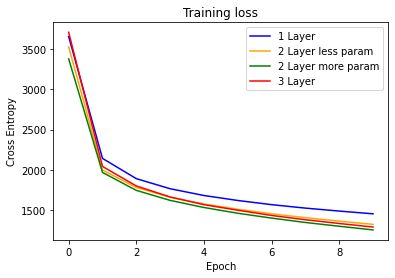

In [35]:
a,b,c,d = model_trained1, model_trained2,model_trained3, model_trained4

print('Training Loss')
fig = plt.figure()

plt.plot(range(0,10), a[1], color='b', label='1 layer')
plt.plot(range(0,10), b[1], color='orange', label='2 layer less param')
plt.plot(range(0,10), c[1], color='g', label='2 layer more param')
plt.plot(range(0,10), d[1], color='r', label='3 layer')
plt.legend(('1 Layer', '2 Layer less param', '2 Layer more param', '3 Layer'))

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")

plt.savefig("./multimodel_cross_epoch.jpg")
files.download('multimodel_cross_epoch.jpg')

## Explaination output 1 :
- From the graph above, 2 layer more param shows the least loss.
- We can explain that suitable layer which are not too deep and not to shallow will predict the model better. Therefore, getting best model requires time for tuning and defining.
- Having same layer but more param helps model learn more and better features which in result better performance and lesser lost/error. But above also shows that the 3 layer with more params is perform worser than layer 2 more param model.
- We can conclude that a suitable layer and param will perform well.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

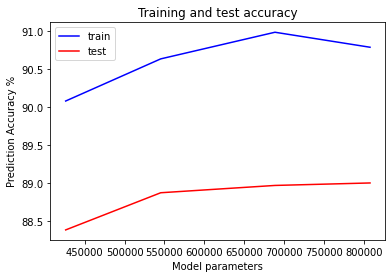

In [48]:
paramList = [426031,545327,688687,807983]
point1 = a[4][-1]
point2 = b[4][-1]
point3 = c[4][-1]
point4 = d[4][-1]

train_y = [point1, point2, point3, point4]

point1 = a[5]
point2 = b[5]
point3 = c[5]
point4 = d[5]

test_y = [point1, point2, point3, point4]

plt.plot(paramList, train_y, color='b', label='train')
plt.plot(paramList, test_y, color='r', label='test')

plt.legend(('train','test'))

plt.title("Training and test accuracy")
plt.xlabel("Model parameters")
plt.ylabel("Prediction Accuracy %")

plt.savefig("./multimodel_pred_param.jpg")
files.download('multimodel_pred_param.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

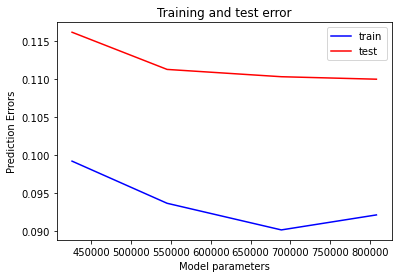

In [49]:
trainL = len(train)
testL = len(test)

point1 = (100 - a[4][-1])/100
point2 = (100 - b[4][-1])/100
point3 = (100 - c[4][-1])/100
point4 = (100 - d[4][-1])/100

train_y = [point1, point2, point3, point4]

point1 = (100 - a[5])/100
point2 = (100 - b[5])/100
point3 = (100 - c[5])/100
point4 = (100 - d[5])/100

test_y = [point1, point2, point3, point4]

plt.plot(paramList, train_y, color='b', label='train')
plt.plot(paramList, test_y, color='r', label='test')

plt.legend(('train','test'))


# [epochList, lossList, batchList, batchLoss,accuracy_list,testAccuracy,testError]

plt.title("Training and test error")
plt.xlabel("Model parameters")
plt.ylabel("Prediction Errors")

plt.savefig("./multimodel_error_param.jpg")
files.download('multimodel_error_param.jpg')

## Explaination output 2:
- Both of the graph shows that the loss and accuracy are starting to show opposite results when it almost reaches 700000 params 
- Futher testing to see whether having more layers and params will show more clear results.

## Further experiment

In [13]:
#create more complex class with one more layer
class MLP4(nn.Module):
  def __init__(self,input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,num_classes):
    super(MLP4,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size1) 
    self.layer2 = nn.Linear(hidden_size1,hidden_size2)
    self.layer3 = nn.Linear(hidden_size2,hidden_size3)
    self.layer4 = nn.Linear(hidden_size3,hidden_size4)
    self.layer5 = nn.Linear(hidden_size4,num_classes)

  def forward(self,x): 

    out = self.layer1(x)
    out = torch.sigmoid(out)
    out = self.layer2(out)
    out = torch.sigmoid(out)
    out = self.layer3(out)
    out = torch.sigmoid(out)
    out = self.layer4(out)
    out = torch.sigmoid(out)
    out = self.layer5(out)
 
    if not self.training:
      out = F.softmax(out,dim=1)
    return out

In [14]:
# Get Overfitting training results
def train_overfit(model,train_loader,test_loader):
  total_train = len(train)
  total_test = len(test)

  loss_fn = nn.CrossEntropyLoss() 
  opt = torch.optim.Adam(model.parameters()) #optimizer, optimization strategy-to escape the local minima and to converge quickly
  train_loss_list = []
  test_loss_list = []
  train_accuracy_list =[]
  test_accuracy_list =[]

  for epoch in range(30):
    model.train() #training mode
    train_loss = 0
    test_loss = 0
    train_correct = 0
    test_correct = 0

    for input_batch, target_batch in train_loader:

      opt.zero_grad() #zero the gradients
      predict_batch = model(input_batch) #fwd
      loss_batch = loss_fn(predict_batch,target_batch) #loss
      loss_batch.backward() #backward

      opt.step()#optimize i.e update weights

      train_loss += loss_batch.item()
      _, prediction = torch.max(predict_batch, dim=1)
      train_correct += torch.sum(prediction==target_batch).item()
      
    train_accuracy = train_correct/total_train*100
    train_loss_list.append(train_loss)    
    train_accuracy_list.append(train_accuracy)

    with torch.no_grad():
      for input_batch, target_batch in test_loader:

        opt.zero_grad() #zero the gradients
        predict_batch = model(input_batch) #fwd
        loss_batch = loss_fn(predict_batch,target_batch) #loss

        test_loss += loss_batch.item()

        _, prediction = torch.max(predict_batch, dim=1)
        test_correct += torch.sum(prediction==target_batch).item()

      test_accuracy = test_correct/total_test*100
      test_loss_list.append(test_loss)    
      test_accuracy_list.append(test_accuracy)

    print(f'Epoch: {epoch+1}  train loss: {train_loss}  train accuracy: {train_accuracy}    test loss: {test_loss} test accuracy: {test_accuracy}')
  
  return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list

In [27]:
model5 = MLP4(784, 512, 512, 512 ,256, 47)

print("4 layer model - model 5\n" )
print(summary(model5, torch.zeros((1, 784)), show_input=False)+'\n')


4 layer model - model 5

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 512]         401,920         401,920
          Linear-2            [1, 512]         262,656         262,656
          Linear-3            [1, 512]         262,656         262,656
          Linear-4            [1, 256]         131,328         131,328
          Linear-5             [1, 47]          12,079          12,079
Total params: 1,070,639
Trainable params: 1,070,639
Non-trainable params: 0
-----------------------------------------------------------------------



In [28]:
#train complex model
train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train_overfit(model5,train_loader,test_loader)
overfit_result = [train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list]

Epoch: 1  train loss: 4153.905267000198  train accuracy: 76.47206318094027    test loss: 401.6609491109848 test accuracy: 84.97975464869373
Epoch: 2  train loss: 2154.216828495264  train accuracy: 86.32932721239318    test loss: 338.41128635406494 test accuracy: 86.94067381343329
Epoch: 3  train loss: 1874.948687016964  train accuracy: 87.76628668695517    test loss: 314.44961212575436 test accuracy: 87.71438150666678
Epoch: 4  train loss: 1721.6688443124294  train accuracy: 88.54917097940773    test loss: 296.24692064523697 test accuracy: 88.2955219518066
Epoch: 5  train loss: 1618.3137329146266  train accuracy: 89.076586257687    test loss: 292.54583210498095 test accuracy: 88.44252641352097
Epoch: 6  train loss: 1539.0521349310875  train accuracy: 89.51000957113301    test loss: 298.13249569386244 test accuracy: 88.27488974665371
Epoch: 7  train loss: 1475.5075745284557  train accuracy: 89.83153086547114    test loss: 282.3028597086668 test accuracy: 88.83281896099653
Epoch: 8  trai

Text(0, 0.5, 'Cross Entropy Loss')

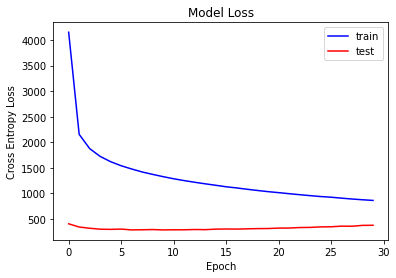

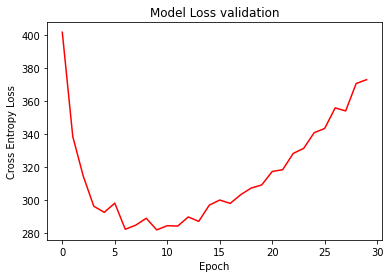

In [57]:
#plot
plt.figure(0)

plt.plot(range(0,30), train_loss_list, label='train' ,color = 'b')
plt.plot(range(0,30), test_loss_list, label='test', color='r')
plt.legend(('train','test'))
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
# plt.savefig("./model_loss.jpg")
# files.download('model_loss.jpg')

plt.figure(1)

plt.plot(range(0,30), test_loss_list, label='test', color='r')
plt.title("Model Loss validation")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")


Text(0, 0.5, 'Cross Entropy Loss')

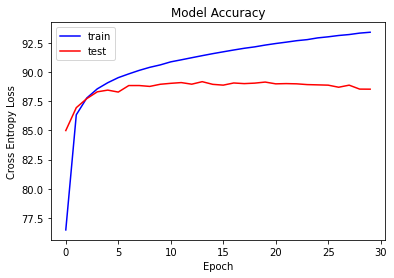

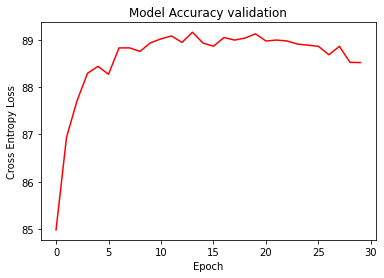

In [60]:
plt.figure(0)

plt.plot(range(0,30), train_accuracy_list, label='train', color='b')
plt.plot(range(0,30), test_accuracy_list, label='test', color='r')
plt.legend(('train','test'))
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

# plt.savefig("./model_accuracy.jpg")
# files.download('model_accuracy.jpg')

plt.figure(1)

plt.plot(range(0,30), test_accuracy_list, label='test', color='r')
plt.title("Model Accuracy validation")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

## Explaination on experiment:
- new model - model5 - MLP4(784, 512, 512, 512 ,256, 47) is created
- it has added one hidden layer to the complexity and more params (1,070,639)
- 30 epochs have done to see how well the model goes
- both of the graph shows that the model has become overfitting when the training goes on after n number of epochs.
- training loss are dropping while the testing validation are remains or with small increase after some epoch after n number of epoch
- training accuracy are increasing well but the testing validation accuracy  drops after n number of epochs
- this shows that the model overfitting to the training dataset and unable to generalize and predict the testing dataset well and hence the testing dataset are unable to have better predictions.